In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import beta
import plotly.express as px
from datetime import datetime
from dotenv import load_dotenv
from snowflake import connector

import warnings
# Filter out all warnings
warnings.filterwarnings('ignore', category=Warning)

In [118]:
load_dotenv('/Users/peter/.env')

# establish Snowflake connection
connection = connector.connect(user=os.getenv("SNOWFLAKE_USERNAME"), 
                  password=os.getenv("SNOWFLAKE_PASSWORD"), 
                  account=os.getenv("SNOWFLAKE_ACCOUNT"), 
                  role=os.getenv("SNOWFLAKE_ROLE"), 
                  warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
                  database = 'DISCO_CORE' 
                  )

# # Set OpenAI API key
# openai.api_key = os.getenv("OPENAI_API_KEY")

## Prepare Data

### Ingest Data

In [119]:
raw_daily_display_query = """
select 
    to_date(event_created_at) as event_date,
    -- widget_type,
    -- ml_model,
    case 
        when widget_type = 'DISCOFEED' and ml_model not ilike '%waterfall%' and e.ml_model != 'contextual' then 'bert_boost_classic'
        when ml_model ilike '%waterfall%' then 'waterfall'
        when widget_type = 'LEAD_GEN' then 'nurture'
        when ml_model = 'contextual' and widget_type != 'LEAD_GEN' then 'contextual_classic'
        else 'other' 
    end as load_type,
    count(distinct event_id) as brand_displays
from event.event e 
where
    event_name = 'widget_brand_display'
    and to_date(event_created_at) between '2024-02-29' and current_date -1
    -- and ml_model is null
    and brand_name != publisher_name
group by all 
order by event_date asc
"""

raw_daily_display = pd.read_sql(raw_daily_display_query, connection)
#change all columns to lower case
raw_daily_display.columns = map(str.lower, raw_daily_display.columns)

In [120]:
raw_zero_day_adspend_query = """
with conv_table as (
select *
from playground_analytics.derived__conversion_ordermap_fix 
where to_date(order_created_at) between '2024-02-01' and '2024-03-31'
union all 
select *
from derived.conversion 
where to_date(order_created_at) between '2024-04-01' and current_date -1
)
select 
    to_date(c.event_created_at) as event_date,
    case 
        when e.widget_type = 'DISCOFEED' and e.ml_model not ilike '%waterfall%' and e.ml_model != 'contextual' then 'bert_boost_classic'
        when e.ml_model ilike '%waterfall%' then 'waterfall'
        when e.widget_type = 'LEAD_GEN' then 'nurture'
        when e.ml_model = 'contextual' and e.widget_type != 'LEAD_GEN' then 'contextual_classic'
        else 'other' 
    end as load_type,
    sum(case when billable_amount is null then 0 else billable_amount end) as zeroday_ad_spend
from conv_table c
left join curated.ad_spend_revenue asr using (order_id)
left join event.event e on e.event_id = c.event_id
where 
    c.conversion_type = 'cross-sell'
    and to_date(c.event_created_at) between '2024-02-29' and current_date -1
    and c.days_to_attribution = 0
group by all 
order by event_date asc
;
"""

raw_zero_day_adspend = pd.read_sql(raw_zero_day_adspend_query, connection)
#change all columns to lower case
raw_zero_day_adspend.columns = map(str.lower, raw_zero_day_adspend.columns)

In [121]:
final_conv_query = """
with conv_table as (
select *
from playground_analytics.derived__conversion_ordermap_fix 
where to_date(order_created_at) between '2024-02-01' and '2024-03-31'
union all 
select *
from derived.conversion 
where to_date(order_created_at) between '2024-04-01' and current_date -1
)
select 
    to_date(c.event_created_at) as event_date,
        -- case 
    --     when e.widget_type = 'DISCOFEED' and e.ml_model not ilike '%waterfall%' and e.ml_model != 'contextual' then 'bert_boost_classic'
    --     when e.ml_model ilike '%waterfall%' then 'waterfall'
    --     when e.widget_type = 'LEAD_GEN' then 'nurture'
    --     when e.ml_model = 'contextual' and e.widget_type != 'LEAD_GEN' then 'contextual_classic'
    --     else 'other' 
    -- end as load_type,
    count(distinct c.order_id) as final_conv_count,
    sum(case when billable_amount is null then 0 else billable_amount end) as final_ad_spend,
    -- count(case when c.customer_type = 'new' then 1 else null end) / count(distinct c.order_id) as new_cust_rate,
    -- count(case when c.event_classification = 'click' then 1 else null end) / count(distinct c.order_id) as click_rate,
from event.event e 
left join conv_table c using (event_id)
left join curated.ad_spend_revenue asr on c.order_id = asr.order_id
where 
    c.conversion_type = 'cross-sell'
    and to_date(c.event_created_at) between '2024-02-29' and current_date -1
    -- and c.days_to_attribution = 0
group by all 
order by event_date asc
;
"""

final_conv = pd.read_sql(final_conv_query, connection)
#change all columns to lower case
final_conv.columns = map(str.lower, final_conv.columns)

In [122]:
daily_order_query = """
select 
    to_date(created_at_gmt) as event_date,
    count(distinct order_id) as order_count
from orders.order_data_flattened
where 
    to_date(created_at_gmt) between '2024-02-29' and current_date-1
group by all
order by event_date asc
;
"""

daily_order = pd.read_sql(daily_order_query, connection)
#change all columns to lower case
daily_order.columns = map(str.lower, daily_order.columns)

### Organize Data

In [123]:
#Pivot the data by load type
display_pivot = raw_daily_display.pivot(index='event_date', columns='load_type', values='brand_displays').reset_index()
#fill NaN values with 0
display_pivot = display_pivot.fillna(0)
#remove the index name
display_pivot.columns.name = None
#add a subscript of "_displays" to all of the columns except 'event_data' 
display_pivot.columns = ['event_date'] + [col + '_displays' for col in display_pivot.columns[1:]]
display_pivot.sample(5)

,event_date,bert_boost_classic_displays,contextual_classic_displays,nurture_displays,other_displays,waterfall_displays
33,2024-04-02,223873.0,12559.0,22280.0,8068.0,65195.0
9,2024-03-09,247477.0,35505.0,18063.0,15.0,42591.0
44,2024-04-13,258604.0,14395.0,24573.0,8135.0,0.0
12,2024-03-12,261149.0,34741.0,14187.0,14.0,41108.0
20,2024-03-20,261382.0,34134.0,15756.0,15.0,37503.0


In [124]:
#Pivot the zero day ad spend data by load type
zero_day_adspend_pivot = raw_zero_day_adspend.pivot(index='event_date', columns='load_type', values='zeroday_ad_spend').reset_index()
#fill NaN values with 0
zero_day_adspend_pivot = zero_day_adspend_pivot.fillna(0)
#remove the index name
zero_day_adspend_pivot.columns.name = None
#add a subscript of "_ad_spend" to all of the columns except 'event_data'
zero_day_adspend_pivot.columns = ['event_date'] + [col + '_0day_adspend' for col in zero_day_adspend_pivot.columns[1:]]
zero_day_adspend_pivot.sample(5)

,event_date,bert_boost_classic_0day_adspend,contextual_classic_0day_adspend,nurture_0day_adspend,other_0day_adspend,waterfall_0day_adspend
57,2024-04-26,1690.96,220.00,122.0,182.0,288.00
51,2024-04-20,1471.85,0.00,86.0,90.0,260.98
12,2024-03-12,1779.61,70.00,35.0,10.0,185.00
15,2024-03-15,1735.00,232.29,0.0,20.0,90.00
63,2024-05-02,1439.72,270.00,110.0,40.0,239.00


In [125]:
#merge the two dataframes on 'event_date'
merged_df = pd.merge(display_pivot, zero_day_adspend_pivot, on='event_date')
#merge the daily order data
merged_df = pd.merge(merged_df, daily_order, on='event_date')
#merge the final conversion data
merged_df = pd.merge(merged_df, final_conv, on='event_date')
#calculate rpl as final_ad_spend divided by the sum of all the display columns
merged_df['rpl'] = round(merged_df['final_ad_spend'] / merged_df.iloc[:, 1:5].sum(axis=1),3)
#calculate the conversion rate as final_conv_count divided by the sum of all the display columns
merged_df['conversion_rate'] = round(merged_df['final_conv_count'] / merged_df.iloc[:, 1:5].sum(axis=1),4)
#convert the event_date column to datetime
merged_df['event_date'] = pd.to_datetime(merged_df['event_date'])
#Add a day of week column
merged_df['day_of_week'] = merged_df['event_date'].dt.dayofweek
#Add a day count column that counts the number of days since the start of the dataset
merged_df['day_count'] = range(1, len(merged_df)+1)
#add a day of month column
# merged_df['day_of_month'] = merged_df['event_date'].dt.day
# merged_df.sample(5)

## Model Leading Indicator

In [58]:
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from functools import partial

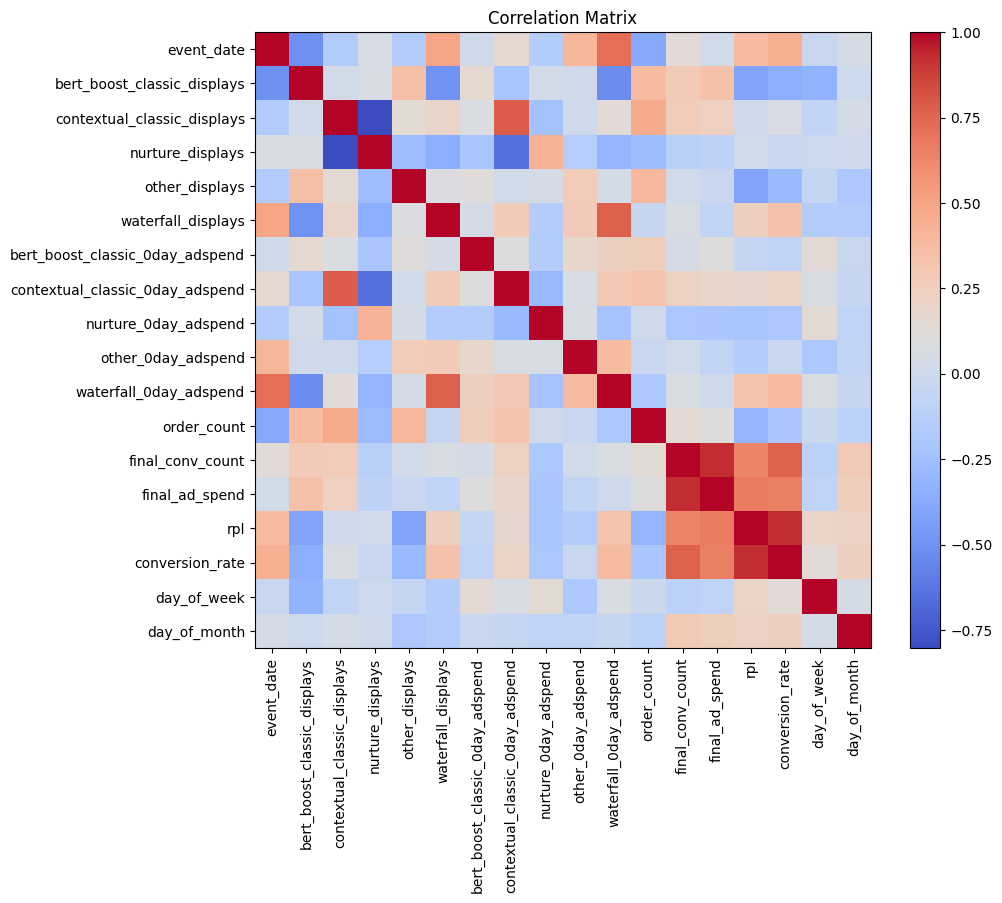

In [78]:
#Generate Correlation Matrix
corr_matrix = merged_df.corr()

# Plot correlation matrix
plt.figure(figsize=(10,8))
plt.title("Correlation Matrix")
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

### Try Modeling Approach on Total Ad Spend as Y

In [126]:
#set up standard scaler
scaler = StandardScaler()
#copy the merged_df dataframe
scaled_df = merged_df.copy()

#isolate the features as all columns except 'event_date', 'rpl', 'conversion_rate', 'final_conv_count', 'final_ad_spend' 
X = scaled_df.drop(columns=['event_date', 'rpl', 'conversion_rate', 'final_conv_count', 'final_ad_spend'])
Y = merged_df[['rpl', 'final_ad_spend']]

# #scale the input data
X_scaled = scaler.fit_transform(X)
#Append the scaled data to the scaled_df dataframe
scaled_df[X.columns] = X_scaled
scaled_df.head()

,event_date,bert_boost_classic_displays,contextual_classic_displays,nurture_displays,other_displays,waterfall_displays,bert_boost_classic_0day_adspend,contextual_classic_0day_adspend,nurture_0day_adspend,other_0day_adspend,waterfall_0day_adspend,order_count,final_conv_count,final_ad_spend,rpl,conversion_rate,day_of_week,day_count
0,2024-02-29,0.718446,1.657526,-0.041980,5.047385,-0.068799,0.326803,0.318888,1.236675,-1.068632,-0.516400,3.334505,482,6958.19,0.017,0.0012,0.0,-1.709701
1,2024-03-01,1.498158,0.320829,-0.902221,2.383598,-0.242372,0.310438,1.436269,0.636650,-0.274800,-1.122434,3.033029,428,6077.36,0.016,0.0012,0.5,-1.664709
2,2024-03-02,1.517348,0.771005,-1.295141,1.737857,-0.394051,0.927728,-0.133494,1.032666,0.618261,-0.351119,1.360721,404,6051.19,0.016,0.0011,1.0,-1.619717
3,2024-03-03,-0.090196,0.325777,-1.312673,1.632167,-0.602367,0.028585,-0.101827,-0.623403,-0.274800,-0.296025,0.448103,385,6303.22,0.021,0.0013,1.5,-1.574724
4,2024-03-04,1.555151,0.633723,-1.104795,2.508022,-0.227694,0.195607,-0.599446,-0.179384,1.114407,-0.984699,0.604500,371,5756.47,0.015,0.0010,-1.5,-1.529732


In [127]:
def optimize_random_forest_hyperparameters(X_train, y_train):

    # Define the model
    rf = RandomForestRegressor(random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Define the scorer
    scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # Setup the grid search
    grid_search = GridSearchCV(estimator=rf,
                            param_grid=param_grid,
                            scoring=scorer,
                            cv=5,  # 5-fold cross-validation
                            n_jobs=-1,  # Use all available cores
                            verbose=1)

    # Fit grid search to the train set
    grid_search.fit(X_train, y_train)

    # Get the best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Best parameters:", best_params)
    return best_model

In [128]:
def find_model_performance(scaled_df, objective = 'final_ad_spend', training_size = 0.8, y = Y):
    df = scaled_df.sort_values('event_date').copy()
    
    #Cut off the last 14 days of data
    current_date = datetime.today().date()
    #set cutoff date to 14 days before the current date
    cutoff_date = pd.Timestamp(current_date - pd.Timedelta(days=14))
    #filter out all rows where the event_date is greater than the cutoff date
    df = df[merged_df['event_date'] < cutoff_date]
    # #remove the last 14 rows from the Y dataframe
    # y = y.iloc[:-14]
    
    #Setup y and X variables
    y = df[objective]
    X = df.drop(columns=['event_date', 'final_conv_count', 'final_ad_spend', 'conversion_rate', 'rpl'])

    # #Scale the X data using MinMaxScaler
    # scaler = MinMaxScaler()
    # X_scaled = scaler.fit_transform(X)

    # #Create a train, test split for linear regression and random forest model
    # X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    # # X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(X, y, test_size=0.2, random_state=42)

    #Determine the nearest integer to 70% of the length of the dataset
    train_size = round(len(X) * training_size)
    #Set the first 70% of the dataset as the training set
    X_train = X[:train_size]
    y_train = y[:train_size]
    #Set the remaining 30% of the dataset as the test set
    X_test = X[train_size:]
    y_test = y[train_size:]

    # Fit the Linear Regression model
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)
    y_pred_lr = linear_reg.predict(X_test)
    y_train_pred_lr = linear_reg.predict(X_train)  # Predictions on the training set

    # Calculate Errors on test and train data for Linear Regression
    lr_rmse_test = mean_squared_error(y_test, y_pred_lr, squared=False)
    lr_rmse_train = mean_squared_error(y_train, y_train_pred_lr, squared=False)
    mean_abs_error_pct_lr_test = round((abs(y_test - y_pred_lr) / y_test).mean(),3)
    mean_abs_error_pct_lr_train = round((abs(y_train - y_train_pred_lr) / y_train).mean(),3)

    #Optimize the Random Forest model and predict on the test data
    best_rf_model = optimize_random_forest_hyperparameters(X_train, y_train)
    y_pred_rf = best_rf_model.predict(X_test)
    y_train_pred_rf = best_rf_model.predict(X_train)  # Predictions on the training set

    # Calculate Errors on test and train data for Random Forest
    rf_rmse_test = mean_squared_error(y_test, y_pred_rf, squared=False)
    rf_rmse_train = mean_squared_error(y_train, y_train_pred_rf, squared=False)
    mean_abs_error_pct_rf_test = round((abs(y_test - y_pred_rf) / y_test).mean(),3)
    mean_abs_error_pct_rf_train = round((abs(y_train - y_train_pred_rf) / y_train).mean(),3)

    # Save the results to a dataframe with additional columns for training errors
    results = pd.DataFrame({
        'model': ['Linear Regression', 'Random Forest'],
        'RMSE Test': [lr_rmse_test, rf_rmse_test],
        'RMSE Train': [lr_rmse_train, rf_rmse_train],
        'Mean Abs Error % Test': [mean_abs_error_pct_lr_test, mean_abs_error_pct_rf_test],
        'Mean Abs Error % Train': [mean_abs_error_pct_lr_train, mean_abs_error_pct_rf_train]
    })

    #Plot a scatter plot of the actual vs predicted values for both models with different colors for each model and a y=x line
    plt.figure(figsize=(8,3))
    plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')
    plt.scatter(y_test, y_pred_rf, color='red', label='Random Forest')
    #Insert label based on the objective variable
    plt.xlabel(f'Actual {objective}')
    plt.ylabel(f'Predicted {objective}')
    plt.title(f'Actual vs Predicted {objective} by Model Type')
    plt.legend()    
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='black')
    plt.show()

    return results, linear_reg, best_rf_model
    # return results

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


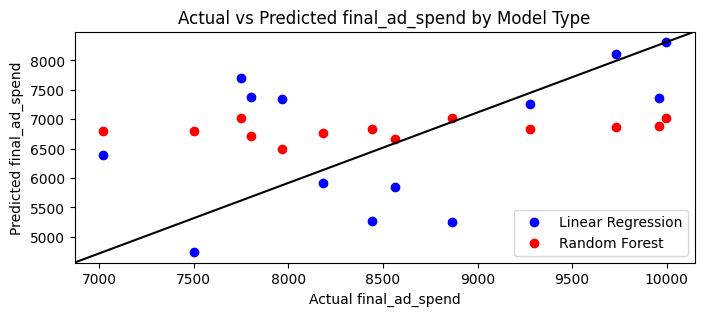

,model,RMSE Test,RMSE Train,Mean Abs Error % Test,Mean Abs Error % Train
0,Linear Regression,2158.006944,480.060492,0.214,0.057
1,Random Forest,1933.607376,507.881741,0.193,0.058


In [129]:
adspend_results, adspend_lr_model, adspend_rf_model = find_model_performance(scaled_df)
adspend_results

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


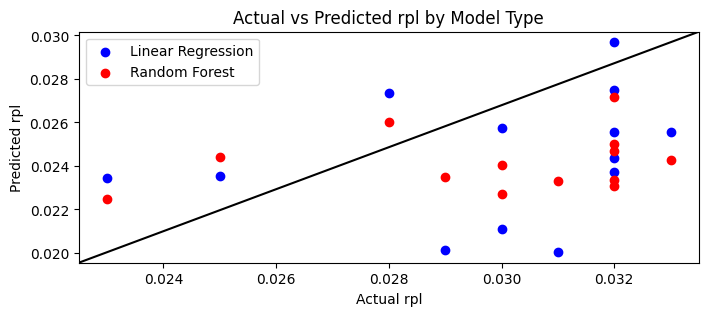

,model,RMSE Test,RMSE Train,Mean Abs Error % Test,Mean Abs Error % Train
0,Linear Regression,0.006497,0.001559,0.180,0.053
1,Random Forest,0.006441,0.000862,0.185,0.030


In [130]:
rpl_results, rpl_lr_model, rpl_rf_model = find_model_performance(scaled_df, objective='rpl')
rpl_results

### XgBoost

In [131]:
# #Replit the data for XGBoost to include a train, test and validation set in a 80/10/10 split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.125, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

xg_data = scaled_df.copy()
#Remove the last 14 rows of data
xg_data = xg_data.iloc[:-14]
#remove the columns that are not features
xg_features = xg_data.drop(columns=['event_date', 'final_conv_count', 'final_ad_spend', 'conversion_rate', 'rpl'])
y_xg = xg_data['rpl']

#Set the first 80% of the data as the training set
train_size = int(len(xg_features) * 0.8)
X_train_xg = xg_features[:train_size]
y_train_xg = y_xg[:train_size]

#Set the next 10% of the data as the validation set
val_size = int(len(xg_features) * 0.9)
X_val_xg = xg_features[train_size:val_size]
y_val_xg = y_xg[train_size:val_size]

#Set the last 10% of the data as the test set
X_test_xg = xg_features[val_size:]
y_test_xg = y_xg[val_size:]

# #Initialize the XGBoost model
train_data = xgb.DMatrix(X_train_xg, label=y_train_xg)
valid_data = xgb.DMatrix(X_val_xg, label=y_val_xg)

In [132]:
# Set the parameters for the XGBoost model
params = {
    'learning_rate': 0.001,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    # 'lambda': 1,  # L2 regularization
    # 'alpha': 0.1  # L1 regularization  
}

def mape_objective(preds, dtrain):
    labels = dtrain.get_label()
    # Avoid division by zero
    elements = np.where(labels != 0, np.abs((labels - preds) / labels), 0)
    grad = np.where(labels != 0, -100 * (labels - preds) / (labels ** 2), 0)  # Gradient
    hess = np.where(labels != 0, 100 / np.abs(labels), 0)  # Hessian

    return grad, hess

#Train the data
num_rounds = 1000
watchlist = [(train_data, 'train'), (valid_data, 'valid')]

initial_model = xgb.train(
    params,
    train_data,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=50,
    obj=mape_objective,  # Use the custom MAPE objective function
    feval=None,  # Temporarily set feval to None
    maximize=False,
    verbose_eval=10,
)

[0]	train-rmse:0.45570	valid-rmse:0.45313
[10]	train-rmse:0.29059	valid-rmse:0.30557
[20]	train-rmse:0.18719	valid-rmse:0.20525
[30]	train-rmse:0.12172	valid-rmse:0.13917
[40]	train-rmse:0.07986	valid-rmse:0.09490
[50]	train-rmse:0.05282	valid-rmse:0.06506
[60]	train-rmse:0.03517	valid-rmse:0.04502
[70]	train-rmse:0.02355	valid-rmse:0.03101


[80]	train-rmse:0.01597	valid-rmse:0.02166
[90]	train-rmse:0.01099	valid-rmse:0.01601
[100]	train-rmse:0.00757	valid-rmse:0.01170
[110]	train-rmse:0.00527	valid-rmse:0.00873
[120]	train-rmse:0.00374	valid-rmse:0.00688
[130]	train-rmse:0.00268	valid-rmse:0.00585
[140]	train-rmse:0.00191	valid-rmse:0.00514
[150]	train-rmse:0.00138	valid-rmse:0.00451
[160]	train-rmse:0.00103	valid-rmse:0.00430
[170]	train-rmse:0.00076	valid-rmse:0.00407
[180]	train-rmse:0.00057	valid-rmse:0.00386
[190]	train-rmse:0.00042	valid-rmse:0.00368
[200]	train-rmse:0.00033	valid-rmse:0.00362
[210]	train-rmse:0.00025	valid-rmse:0.00355
[220]	train-rmse:0.00020	valid-rmse:0.00353
[230]	train-rmse:0.00015	valid-rmse:0.00350
[240]	train-rmse:0.00012	valid-rmse:0.00349
[250]	train-rmse:0.00010	valid-rmse:0.00347
[260]	train-rmse:0.00008	valid-rmse:0.00346
[270]	train-rmse:0.00006	valid-rmse:0.00345
[280]	train-rmse:0.00005	valid-rmse:0.00344
[290]	train-rmse:0.00004	valid-rmse:0.00343
[300]	train-rmse:0.00003	valid-rms

In [106]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.005],
    'max_depth': [3, 2],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'lambda': [0.01, 0.005],  # L2 regularization
    'alpha': [0.01, 0.005]    # L1 regularization
}

# Function to perform cross-validation
def perform_cv(dtrain, param_grid, num_rounds=1000, nfolds=5, early_stopping_rounds=50):
    cv_results = {}
    min_mae = float("Inf")
    best_params = None

    for eta in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            for subsample in param_grid['subsample']:
                for colsample in param_grid['colsample_bytree']:
                    for lam in param_grid['lambda']:
                        for alpha in param_grid['alpha']:
                            print(f"CV with learning_rate={eta}, max_depth={max_depth}, subsample={subsample}, colsample={colsample}, lambda={lam}, alpha={alpha}")
                            
                            # Update our parameters
                            params['eta'] = eta
                            params['max_depth'] = max_depth
                            params['subsample'] = subsample
                            params['colsample_bytree'] = colsample
                            params['lambda'] = lam
                            params['alpha'] = alpha
                            
                            # Run CV
                            cv_result = xgb.cv(
                                params,
                                dtrain,
                                num_boost_round=num_rounds,
                                seed=42,
                                nfold=nfolds,
                                metrics={'mae'},
                                early_stopping_rounds=early_stopping_rounds
                            )

                            # Update best MAE
                            mean_mae = cv_result['test-mae-mean'].min()
                            boost_rounds = cv_result['test-mae-mean'].argmin()
                            print(f"MAE {mean_mae} for {boost_rounds} rounds")
                            if mean_mae < min_mae:
                                min_mae = mean_mae
                                best_params = (eta, max_depth, subsample, colsample, lam, alpha)
                                print(f"New best params: {best_params}, MAE: {min_mae}")

    print(f"Best params: {best_params}, Minimum MAE: {min_mae}")
    return best_params

# Load your data into DMatrix
dtrain = xgb.DMatrix(data=X_train_xg, label=y_train_xg)

# Perform cross-validation
best_params = perform_cv(dtrain, param_grid)

CV with learning_rate=0.01, max_depth=3, subsample=0.6, colsample=0.6, lambda=0.01, alpha=0.01
MAE 0.0023713730089366418 for 999 rounds
New best params: (0.01, 3, 0.6, 0.6, 0.01, 0.01), MAE: 0.0023713730089366418
CV with learning_rate=0.01, max_depth=3, subsample=0.6, colsample=0.6, lambda=0.01, alpha=0.005
MAE 0.0022521596712370717 for 999 rounds
New best params: (0.01, 3, 0.6, 0.6, 0.01, 0.005), MAE: 0.0022521596712370717
CV with learning_rate=0.01, max_depth=3, subsample=0.6, colsample=0.6, lambda=0.005, alpha=0.01
MAE 0.002371511651823918 for 999 rounds
CV with learning_rate=0.01, max_depth=3, subsample=0.6, colsample=0.6, lambda=0.005, alpha=0.005
MAE 0.0022518945547441637 for 999 rounds
New best params: (0.01, 3, 0.6, 0.6, 0.005, 0.005), MAE: 0.0022518945547441637
CV with learning_rate=0.01, max_depth=3, subsample=0.6, colsample=0.8, lambda=0.01, alpha=0.01
MAE 0.002360388444115718 for 999 rounds
CV with learning_rate=0.01, max_depth=3, subsample=0.6, colsample=0.8, lambda=0.01, 

In [133]:
optimized_params = {
    'learning_rate': 0.01,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'lambda': 0.01,
    'alpha': 0.01
}

# Train the model with the best parameters
optimized_model = xgb.train(
    params=optimized_params,
    dtrain=train_data,
    num_boost_round=1000,  # You can adjust this based on the earlier cross-validation results
    evals=[(dtrain, 'train')],
    early_stopping_rounds=50,
    verbose_eval=10
)

#Predict on the validation data
val_data = xgb.DMatrix(X_val_xg)
y_pred_val = optimized_model.predict(val_data)

#Predict on the test data
test_data = xgb.DMatrix(X_test_xg)
y_pred_test = optimized_model.predict(test_data)

#Calculate the mean absolute percentage error for the validation and test data
mape_val = np.mean(np.abs((y_val_xg - y_pred_val) / y_val_xg))
mape_test = np.mean(np.abs((y_test_xg - y_pred_test) / y_test_xg))
#Print the mean absolute percentage error for the validation and test data
print(f"Validation MAPE: {mape_val}")
print(f"Test MAPE: {mape_test}")

#Do the same for RMSE
rmse_val = mean_squared_error(y_val_xg, y_pred_val, squared=False)
rmse_test = mean_squared_error(y_test_xg, y_pred_test, squared=False)
print(f"Validation RMSE: {rmse_val}")
print(f"Test RMSE: {rmse_test}")

[0]	train-rmse:0.00347
[10]	train-rmse:0.00331
[20]	train-rmse:0.00317
[30]	train-rmse:0.00305
[40]	train-rmse:0.00293
[50]	train-rmse:0.00281
[60]	train-rmse:0.00272
[70]	train-rmse:0.00263
[80]	train-rmse:0.00255
[90]	train-rmse:0.00248
[100]	train-rmse:0.00241
[110]	train-rmse:0.00234
[120]	train-rmse:0.00229
[130]	train-rmse:0.00224
[140]	train-rmse:0.00219
[150]	train-rmse:0.00214
[160]	train-rmse:0.00210
[170]	train-rmse:0.00207
[180]	train-rmse:0.00204
[190]	train-rmse:0.00200
[200]	train-rmse:0.00197
[210]	train-rmse:0.00194
[220]	train-rmse:0.00192
[230]	train-rmse:0.00190
[240]	train-rmse:0.00188
[250]	train-rmse:0.00186
[260]	train-rmse:0.00184
[270]	train-rmse:0.00182
[280]	train-rmse:0.00181
[290]	train-rmse:0.00179
[300]	train-rmse:0.00178
[310]	train-rmse:0.00176
[320]	train-rmse:0.00175
[330]	train-rmse:0.00174
[340]	train-rmse:0.00173
[350]	train-rmse:0.00172
[360]	train-rmse:0.00171
[370]	train-rmse:0.00171
[380]	train-rmse:0.00170
[390]	train-rmse:0.00169
[400]	train

## Predict Using Dates Within the 14 day cut-off

In [134]:
#identify the current date
current_date = datetime.today().date()
cutoff_date = pd.Timestamp(current_date - pd.Timedelta(days=14))
#Create an alternate dataframe for the last 14 days
prediction_df = scaled_df[scaled_df['event_date'] >= cutoff_date]

#Setup variables for prediction
predict_features = prediction_df.drop(columns=['event_date', 'final_conv_count', 'final_ad_spend', 'conversion_rate', 'rpl'])
# predict_features_scaled = scaler.transform(predict_features)

#Predict the ad spend using both models and add the results to the prediction_df
prediction_df['adspend_lr'] = adspend_lr_model.predict(predict_features)
prediction_df['adspend_rf'] = adspend_rf_model.predict(predict_features)

#Predict the rpl using both models and add the results to the prediction_df
prediction_df['rpl_lr'] = rpl_lr_model.predict(predict_features)
prediction_df['rpl_rf'] = rpl_rf_model.predict(predict_features)
prediction_df['rpl_xg'] = optimized_model.predict(xgb.DMatrix(predict_features))

#keep only the relevant prediction columns and the event_date column
prediction_df = prediction_df[['event_date', 'adspend_lr', 'adspend_rf', 'rpl_lr', 'rpl_rf', 'rpl_xg']]

#add blank columns for 'Actual RPL' and 'Actual Ad Spend' and 'Abs Error %' for each predicted column
prediction_df['actual_ad_spend'] = None
prediction_df['actual_rpl'] = None
prediction_df['adspend_lr_ape'] = None
prediction_df['adspend_rf_ape'] = None
prediction_df['rpl_lr_ape'] = None
prediction_df['rpl_rf_ape'] = None
prediction_df['rpl_xg_ape'] = None

#set the column order as event_date first, and then the rest of the columns in alphabetical order
column_order = ['event_date', 'actual_ad_spend', 'actual_rpl', 'adspend_lr', 'adspend_lr_ape', 'adspend_rf', 'adspend_rf_ape', 'rpl_lr', 'rpl_lr_ape', 'rpl_rf', 'rpl_rf_ape', 'rpl_xg', 'rpl_xg_ape']
prediction_df = prediction_df[column_order]
#Save the prediction_df to a csv file
prediction_df.to_csv(f'data/output/prediction_df_{current_date}.csv', index=False)
prediction_df

,event_date,actual_ad_spend,actual_rpl,adspend_lr,adspend_lr_ape,adspend_rf,adspend_rf_ape,rpl_lr,rpl_lr_ape,rpl_rf,rpl_rf_ape,rpl_xg,rpl_xg_ape
63,2024-05-02,None,None,5604.844419,None,6623.782244,None,0.023856,None,0.024015,None,0.024887,None
64,2024-05-03,None,None,6689.599598,None,6578.575456,None,0.028440,None,0.025885,None,0.024913,None
65,2024-05-04,None,None,6117.488004,None,6363.991785,None,0.030248,None,0.027290,None,0.026370,None
66,2024-05-05,None,None,5903.217410,None,6440.093139,None,0.029949,None,0.026415,None,0.025792,None
67,2024-05-06,None,None,6266.794766,None,6658.072984,None,0.026602,None,0.024960,None,0.025039,None
68,2024-05-07,None,None,6303.864856,None,6679.022044,None,0.025222,None,0.023990,None,0.023143,None
69,2024-05-08,None,None,7675.456729,None,6807.002900,None,0.030469,None,0.024835,None,0.023610,None
70,2024-05-09,None,None,7795.748691,None,6831.663842,None,0.029256,None,0.024015,None,0.022784,None
71,2024-05-10,None,None,6766.062890,None,6629.887767,None,0.027000,None,0.023680,None,0.022938,None
72,2024-05-11,None,None,7023.143786,None,6519.951566,None,0.028820,None,0.024955,None,0.023574,None


## Evaluate Models

### Interpret Feature Importance

In [41]:
#attach the coefficients to the feature names for the linear regression model
lr_coef = pd.DataFrame(adspend_lr_model.coef_, X.columns, columns=['Coefficient'])
#sort the coefficients by absolute value
lr_coef = lr_coef.reindex(lr_coef['Coefficient'].abs().sort_values(ascending=False).index)
lr_coef

,Coefficient
nurture_displays,829.528669
bert_boost_classic_displays,764.516734
waterfall_0day_adspend,480.391562
contextual_classic_displays,381.376432
day_of_week,231.330512
nurture_0day_adspend,-213.874560
day_count,-146.311352
contextual_classic_0day_adspend,-144.474592
bert_boost_classic_0day_adspend,100.066244
order_count,-90.113798


In [42]:
#how to interpret the feature importance of the random forest model
rf_importance = pd.DataFrame(adspend_rf_model.feature_importances_, X.columns, columns=['Importance'])
#sort the importance by value
rf_importance = rf_importance.reindex(rf_importance['Importance'].sort_values(ascending=False).index)
rf_importance

,Importance
bert_boost_classic_displays,0.168106
contextual_classic_0day_adspend,0.145586
waterfall_0day_adspend,0.104088
order_count,0.072549
waterfall_displays,0.066549
day_count,0.062172
bert_boost_classic_0day_adspend,0.060936
day_of_week,0.058812
other_0day_adspend,0.058741
contextual_classic_displays,0.057286


In [43]:
#how to interpret the feature importance of the XGBoost model
xg_importance = pd.DataFrame(optimized_model.get_fscore().items(), columns=['Feature', 'Importance'])
#sort the importance by value
xg_importance = xg_importance.reindex(xg_importance['Importance'].sort_values(ascending=False).index)
xg_importance

,Feature,Importance
3,other_displays,183.0
1,contextual_classic_displays,179.0
5,bert_boost_classic_0day_adspend,174.0
0,bert_boost_classic_displays,165.0
9,waterfall_0day_adspend,147.0
12,day_count,145.0
7,nurture_0day_adspend,140.0
2,nurture_displays,135.0
4,waterfall_displays,116.0
10,order_count,116.0


### Evaluate Directionality

In [135]:
# print(merged_df.shape)
# print(X_scaled.shape)
# print(xg_features.shape)

direction_df = merged_df[['event_date', 'rpl', 'final_ad_spend']]
#change final_ad_spend to ad_spend
direction_df.rename(columns={'final_ad_spend':'ad_spend'}, inplace=True)
#sort by event_date

#Predict RPL of the x_scaled data and add it to the direction_df
direction_df['rpl_lr_pred'] = rpl_lr_model.predict(X_scaled)
direction_df['rpl_rf_pred'] = rpl_rf_model.predict(X_scaled)
xg_data2 = scaled_df.drop(columns=['event_date', 'final_conv_count', 'final_ad_spend', 'conversion_rate', 'rpl'])
direction_df['rpl_xg_pred'] = optimized_model.predict(xgb.DMatrix(xg_data2))
#Predict Ad Spend of the x_scaled data and add it to the direction_df
direction_df['ad_spend_lr_pred'] = adspend_lr_model.predict(X_scaled)
direction_df['ad_spend_rf_pred'] = adspend_rf_model.predict(X_scaled)

#remove the last 14 days/rows from the direction_df
direction_df = direction_df[:-14]
direction_df.sample(5)

,event_date,rpl,ad_spend,rpl_lr_pred,rpl_rf_pred,rpl_xg_pred,ad_spend_lr_pred,ad_spend_rf_pred
23,2024-03-23,0.024,6312.37,0.024669,0.024080,0.024202,6402.003707,6513.624462
46,2024-04-15,0.021,6589.09,0.021469,0.021060,0.020537,6847.279144,6748.008127
60,2024-04-29,0.031,8867.34,0.020032,0.023315,0.024107,5252.939954,7011.851704
61,2024-04-30,0.030,8444.13,0.021081,0.022695,0.023008,5274.446785,6840.594746
40,2024-04-09,0.028,7130.82,0.025236,0.027625,0.026551,6324.067117,6697.928081


In [136]:
def evaluate_directional_accuracy(input_df):
    df = input_df.copy()
    # Calculate the day-to-day changes and percentage changes for actual and predicted values
    model_columns = [col for col in df.columns if 'pred' in col]
    actual_columns = ['rpl', 'ad_spend']

    for col in actual_columns + model_columns:
        df[f'{col}_change'] = df[col].diff()
        df[f'{col}_pct_change'] = df[col].pct_change()

    # Remove the first row since it cannot have a calculated change
    df = df.iloc[1:]

    # Function to determine if directions match
    def direction_matches(actual_change, pred_change):
        return (actual_change * pred_change > 0) or (actual_change == pred_change == 0)

    # Calculate directional accuracy and account for days with actual changes
    results = []
    for actual_col in actual_columns:
        relevant_models = [col for col in model_columns if col.startswith(actual_col.split('_')[0])]
        for model_col in relevant_models:
            matches = df.apply(lambda row: direction_matches(row[f'{actual_col}_change'], row[f'{model_col}_change']), axis=1)
            actual_changes = df[f'{actual_col}_pct_change'] != 0
            correct_count = matches.sum()
            total_count = matches.count()
            actual_change_count = actual_changes.sum()
            correct_on_change_days = matches[actual_changes].sum()

            results.append({
                'Model': model_col,
                'Model Date': datetime.today().date(),
                'Total Days': total_count,
                'Correct Directional Days': correct_count,
                'Directional Accuracy (%)': round(correct_count / total_count, 3),
                'Days with Actual Change': actual_change_count,
                'Correct on Change Days': correct_on_change_days,
                'Accuracy on Change Days (%)': round(correct_on_change_days / actual_change_count , 3) if actual_change_count != 0 else None
            })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    return results_df

# Example usage with your DataFrame:
# results_df = 
directionality = evaluate_directional_accuracy(direction_df)
directionality.to_csv(f'data/output/directionality_{current_date}.csv', index=False)
directionality

,Model,Model Date,Total Days,Correct Directional Days,Directional Accuracy (%),Days with Actual Change,Correct on Change Days,Accuracy on Change Days (%)
0,rpl_lr_pred,2024-05-16,62,45,0.726,53,45,0.849
1,rpl_rf_pred,2024-05-16,62,48,0.774,53,48,0.906
2,rpl_xg_pred,2024-05-16,62,45,0.726,53,45,0.849
3,ad_spend_lr_pred,2024-05-16,62,43,0.694,62,43,0.694
4,ad_spend_rf_pred,2024-05-16,62,46,0.742,62,46,0.742


In [137]:
def identify_directional_inaccuracies(input_df):
    df = input_df.copy()
    # Calculate the day-to-day changes for actual and predicted values
    model_columns = [col for col in df.columns if 'pred' in col]
    actual_columns = ['rpl', 'ad_spend']  # Updated to the correct column names

    # Calculate percentage changes for each column
    for col in actual_columns + model_columns:
        df[f'{col}_change'] = df[col].diff()
        df[f'{col}_pct_change'] = df[col].pct_change().round(3)

    # Function to determine if directions match
    def direction_matches(actual_change, pred_change):
        return (actual_change * pred_change > 0) or (actual_change == pred_change == 0)

    # Analyze each row and collect rows with at least one directional inaccuracy
    incorrect_rows = []

    for index, row in df.iterrows():
        mismatch_found = False
        result_row = {'event_date': row['event_date']}
        
        for actual_col in actual_columns:
            # Extract relevant models for each actual value based on column naming
            relevant_models = [col for col in model_columns if col.startswith(actual_col.split('_')[0])]
            for model_col in relevant_models:
                if not direction_matches(row[f'{actual_col}_change'], row[f'{model_col}_change']):
                    mismatch_found = True
                    result_row[f'{actual_col}_actual_pct_change'] = row[f'{actual_col}_pct_change']
                    result_row[f'{model_col}_model_pct_change'] = row[f'{model_col}_pct_change']

        if mismatch_found:
            incorrect_rows.append(result_row)

    # Create a DataFrame from the results
    incorrect_results_df = pd.DataFrame(incorrect_rows)
    #remove the first row since it cannot have a calculated change
    incorrect_results_df = incorrect_results_df.iloc[1:]
    return incorrect_results_df

direction_details = identify_directional_inaccuracies(direction_df)
direction_details.to_csv(f'data/output/direction_details_{current_date}.csv', index=False)    